# Data Science Task

In [1]:
import pandas as pd
import numpy as np
import os

import librosa
from pydub import AudioSegment
from pydub.utils import make_chunks

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import sklearn.metrics


## 1. Gender Classification

After downloading dev-clean corpus from LibriSpeech, we chunk audios to 2second and use librosa to load each and extract mfcc features. We chose to have 40 mfcc for each audio. Each mfcc is a list of some values extracted from the sound, and its length ranged from forthy to 1024 in our dataset, since this number of features is too high we decided to use the mean of each mfcc as feature. In this way we will loose some info about temporal events in the audio, which does not matter for gender classification.

In [ ]:
path='./LibriSpeech/dev-clean/'
n_mfcc=40
chunk_length_ms = 2000 

li=[]
for adr, dirs, files in os.walk(path):
    for name in files:
        if name.endswith(".flac"):
            
            myaudio = AudioSegment.from_file(os.path.join(adr, name) , "flac") 
#             print(name)
            chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

            #Export all of the individual chunks as wav files
            for i, chunk in enumerate(chunks):
                chunk_name = "chunk{0}.wav".format(i)
#                 print("exporting", chunk_name)
                chunk.export(chunk_name, format="wav")
                sound, sample_rate = librosa.load(chunk_name)
                mfccs = librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=n_mfcc)
                m_mfccs=[]
                for mfcc in mfccs:
                    m_mfccs.append(mfcc.mean())
                li.append([int(name.split('-')[0]),mfccs,m_mfccs])

#             print('end of user'+name.split('-')[0])
df=pd.DataFrame(li,columns=['speaker_id', 'mfccs','mean_mfccs'])

We add a column for each feature for later usage.

In [4]:
for i in range(n_mfcc):
    df['feature_'+str(i)]=df.mean_mfccs.apply(lambda x: x[i])
df.head()

,speaker_id,mfccs,mean_mfccs,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39
0,1272,"[[-522.7668, -515.66626, -513.8235, -519.6458,...","[-329.6405, 100.71635, -3.7250814, 41.976612, ...",-329.640503,100.716347,-3.725081,41.976612,-21.575933,33.390537,-25.432320,...,-2.468185,-0.847701,-0.010971,-5.733699,-2.154388,-4.222409,2.387943,-3.784383,-0.760991,-4.258746
1,1272,"[[-309.9324, -327.0759, -337.67075, -303.2001,...","[-278.42267, 127.35356, -0.73853993, 47.42453,...",-278.422668,127.353561,-0.738540,47.424530,-41.042290,41.758335,-33.498966,...,-5.712534,-2.153524,1.539704,-6.898713,-0.807777,-5.057538,2.615479,-3.570108,1.625968,-4.210540
2,1272,"[[-342.0038, -395.89853, -526.1312, -394.34796...","[-361.6803, 112.33226, 7.6291666, 44.44588, -2...",-361.680298,112.332260,7.629167,44.445881,-29.694118,22.990803,-15.391154,...,-3.255800,0.085542,0.535185,-3.576664,-1.294622,-5.697875,2.193996,-4.098962,-0.940883,-4.067122
3,1272,"[[-560.059, -557.92786, -555.09265, -544.67145...","[-310.25192, 102.72415, 0.71043336, 32.211826,...",-310.251923,102.724152,0.710433,32.211826,-11.045186,30.868523,-20.550585,...,-3.293476,-2.127982,1.661575,-4.571599,-0.720764,-1.521099,2.592067,-2.302302,0.076678,-2.769639
4,1272,"[[-188.79312, -199.19215, -232.25587, -264.300...","[-279.64813, 111.554825, 1.3870921, 52.78167, ...",-279.648132,111.554825,1.387092,52.781670,-24.734667,44.542759,-38.237267,...,-4.886576,-1.953178,-1.848808,-5.931767,-0.678487,-5.501265,2.586416,-6.038486,0.228767,-4.211089


Then we read the data about each speaker from the file provided by LibriSpeech, and add this data to our dataframe.

In [5]:
import re
speaker_df=pd.read_csv("SPEAKERS.TXT", sep="\s\|\s")
speaker_df

C:\Users\ASUS\AppData\Local\Temp/ipykernel_21420/3679664176.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  speaker_df=pd.read_csv("SPEAKERS.TXT", sep="\s\|\s")


,ID,S,DATASET,H,NAME
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine
...,...,...,...,...,...
2479,8975,F,train-clean-100,25.11,Daisy Flaim
2480,9000,M,train-other-500,27.26,Ramon Escamilla
2481,9022,F,train-clean-360,25.17,Claire M
2482,9023,F,train-clean-360,25.19,P. J. Morgan


After analysing not getting goof results for predictions, we suspected that the data might have some problems. There is one female specified as male, and there is someone whose voice frequency is like male but the name is female, as it was hard to recognise we did not consider that person in our analysis.

In [6]:
speaker_df.loc[speaker_df.ID==7976,'S']='F'

In [7]:
df=pd.merge(df,speaker_df, how='left', left_on='speaker_id', right_on='ID')
df.drop(columns=['DATASET','H','NAME', 'ID'], inplace=True)
df

,speaker_id,mfccs,mean_mfccs,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,S
0,1272,"[[-522.7668, -515.66626, -513.8235, -519.6458,...","[-329.6405, 100.71635, -3.7250814, 41.976612, ...",-329.640503,100.716347,-3.725081,41.976612,-21.575933,33.390537,-25.432320,...,-0.847701,-0.010971,-5.733699,-2.154388,-4.222409,2.387943,-3.784383,-0.760991,-4.258746,M
1,1272,"[[-309.9324, -327.0759, -337.67075, -303.2001,...","[-278.42267, 127.35356, -0.73853993, 47.42453,...",-278.422668,127.353561,-0.738540,47.424530,-41.042290,41.758335,-33.498966,...,-2.153524,1.539704,-6.898713,-0.807777,-5.057538,2.615479,-3.570108,1.625968,-4.210540,M
2,1272,"[[-342.0038, -395.89853, -526.1312, -394.34796...","[-361.6803, 112.33226, 7.6291666, 44.44588, -2...",-361.680298,112.332260,7.629167,44.445881,-29.694118,22.990803,-15.391154,...,0.085542,0.535185,-3.576664,-1.294622,-5.697875,2.193996,-4.098962,-0.940883,-4.067122,M
3,1272,"[[-560.059, -557.92786, -555.09265, -544.67145...","[-310.25192, 102.72415, 0.71043336, 32.211826,...",-310.251923,102.724152,0.710433,32.211826,-11.045186,30.868523,-20.550585,...,-2.127982,1.661575,-4.571599,-0.720764,-1.521099,2.592067,-2.302302,0.076678,-2.769639,M
4,1272,"[[-188.79312, -199.19215, -232.25587, -264.300...","[-279.64813, 111.554825, 1.3870921, 52.78167, ...",-279.648132,111.554825,1.387092,52.781670,-24.734667,44.542759,-38.237267,...,-1.953178,-1.848808,-5.931767,-0.678487,-5.501265,2.586416,-6.038486,0.228767,-4.211089,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11080,8842,"[[-510.02405, -512.9276, -518.60956, -519.2312...","[-328.94626, 86.96244, -45.65635, 9.843457, -1...",-328.946259,86.962440,-45.656349,9.843457,-10.945180,-2.456212,-20.364502,...,6.347279,12.293913,9.926215,7.646752,2.512694,2.537924,2.062077,7.178871,5.905984,F
11081,8842,"[[-330.23218, -331.58353, -353.30988, -324.616...","[-328.34973, 102.46651, -59.35243, 18.35467, -...",-328.349731,102.466507,-59.352428,18.354670,-10.913300,4.973919,-31.799513,...,-1.614862,4.309233,2.670313,4.818798,4.184320,7.174394,5.087755,8.450882,7.247018,F
11082,8842,"[[-202.32481, -232.64015, -261.60303, -297.615...","[-304.34537, 98.70923, -51.615875, 33.897343, ...",-304.345367,98.709229,-51.615875,33.897343,-6.610384,-9.490696,-30.535625,...,2.978704,12.014584,12.378379,14.851423,8.316623,4.334272,3.168297,3.915392,3.167552,F
11083,8842,"[[-225.08636, -242.1227, -275.33847, -290.5527...","[-348.84985, 124.86004, -49.205112, 10.148348,...",-348.849854,124.860039,-49.205112,10.148348,0.530439,-11.182297,-7.601807,...,8.660169,12.761537,8.081030,8.824615,5.953966,4.598624,10.260715,6.535206,2.973501,F


In the following we can see the colleration of the features with each others and also the correlation of gender with features.

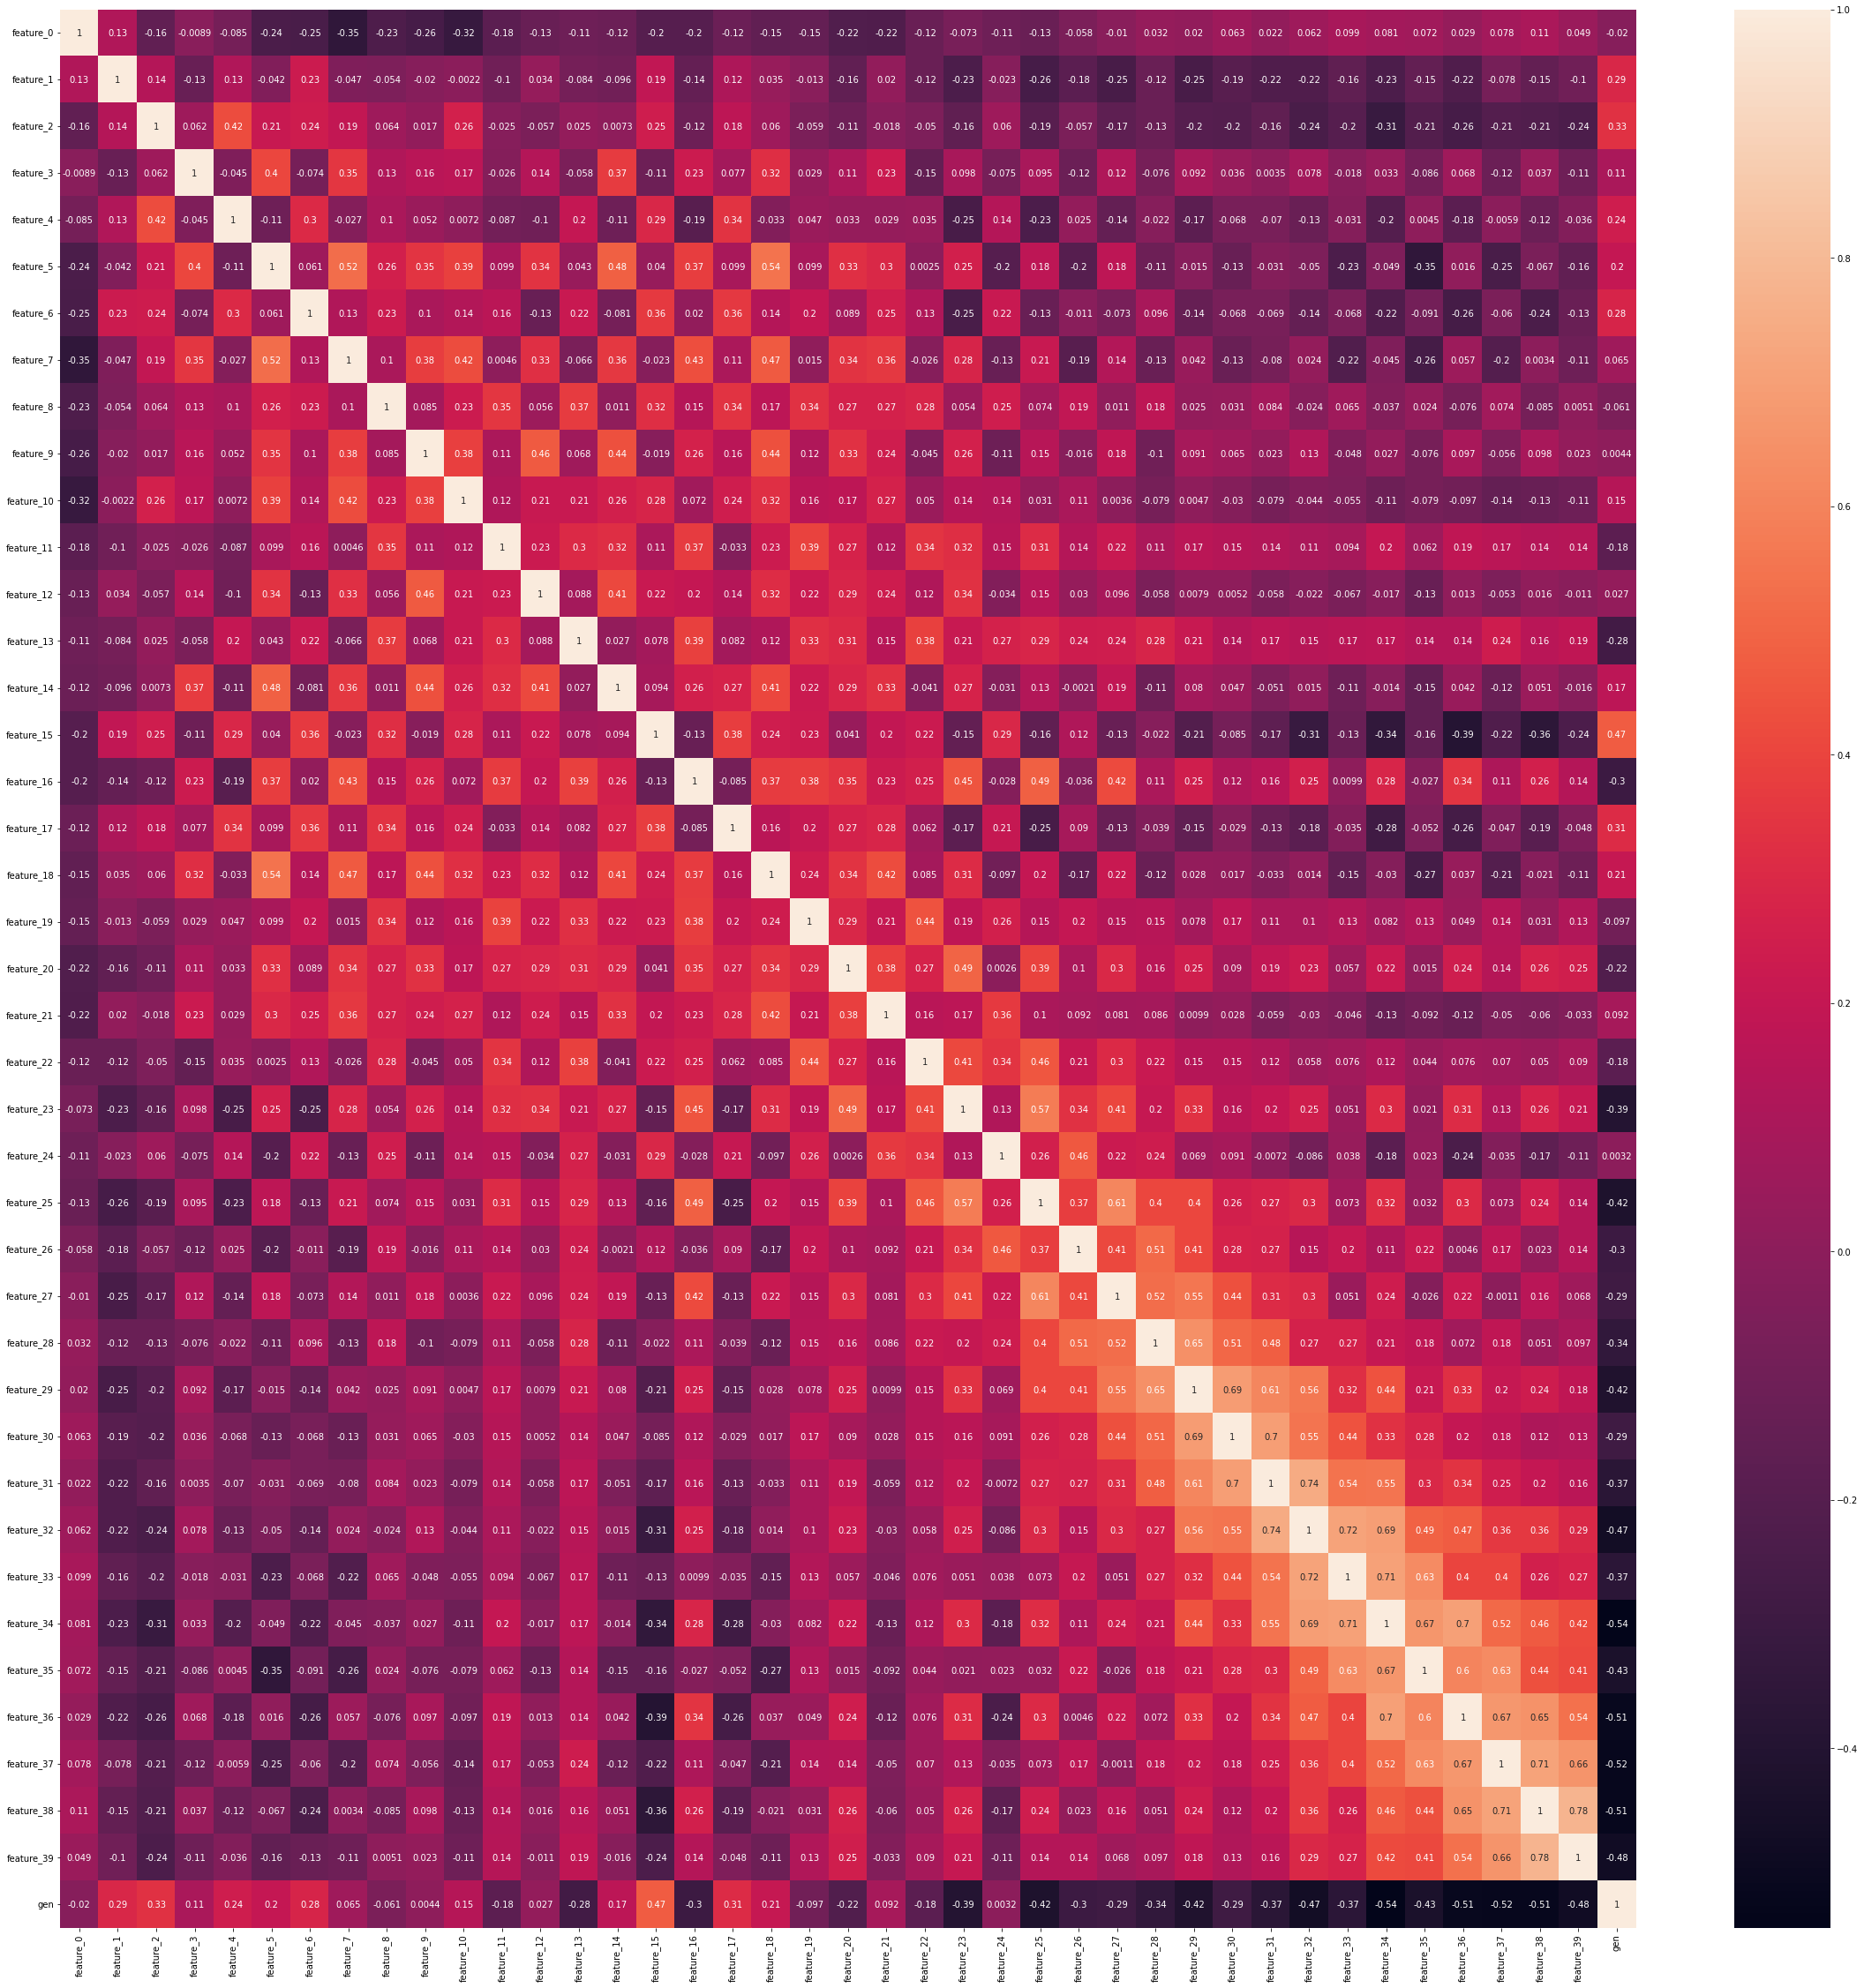

In [8]:
df['gen']= df['S'].apply(lambda x: 0 if (x=='F') else 1)

filter_col = [col for col in df if col.startswith('feature_')]

plt.rcParams["figure.figsize"] = (40,40)

hm = sns.heatmap(df[filter_col+['gen']].corr(), annot = True)

# hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
plt.show()

Now we look at the boxplot of each feature for males and females to get an idea of the existance of outliers. We can see that there are outliers to be considered. (this analysis has been done without chunking the audio files as well, and the number of outliers was much less, this can be because of the silent parts at the end or beginning of the files)

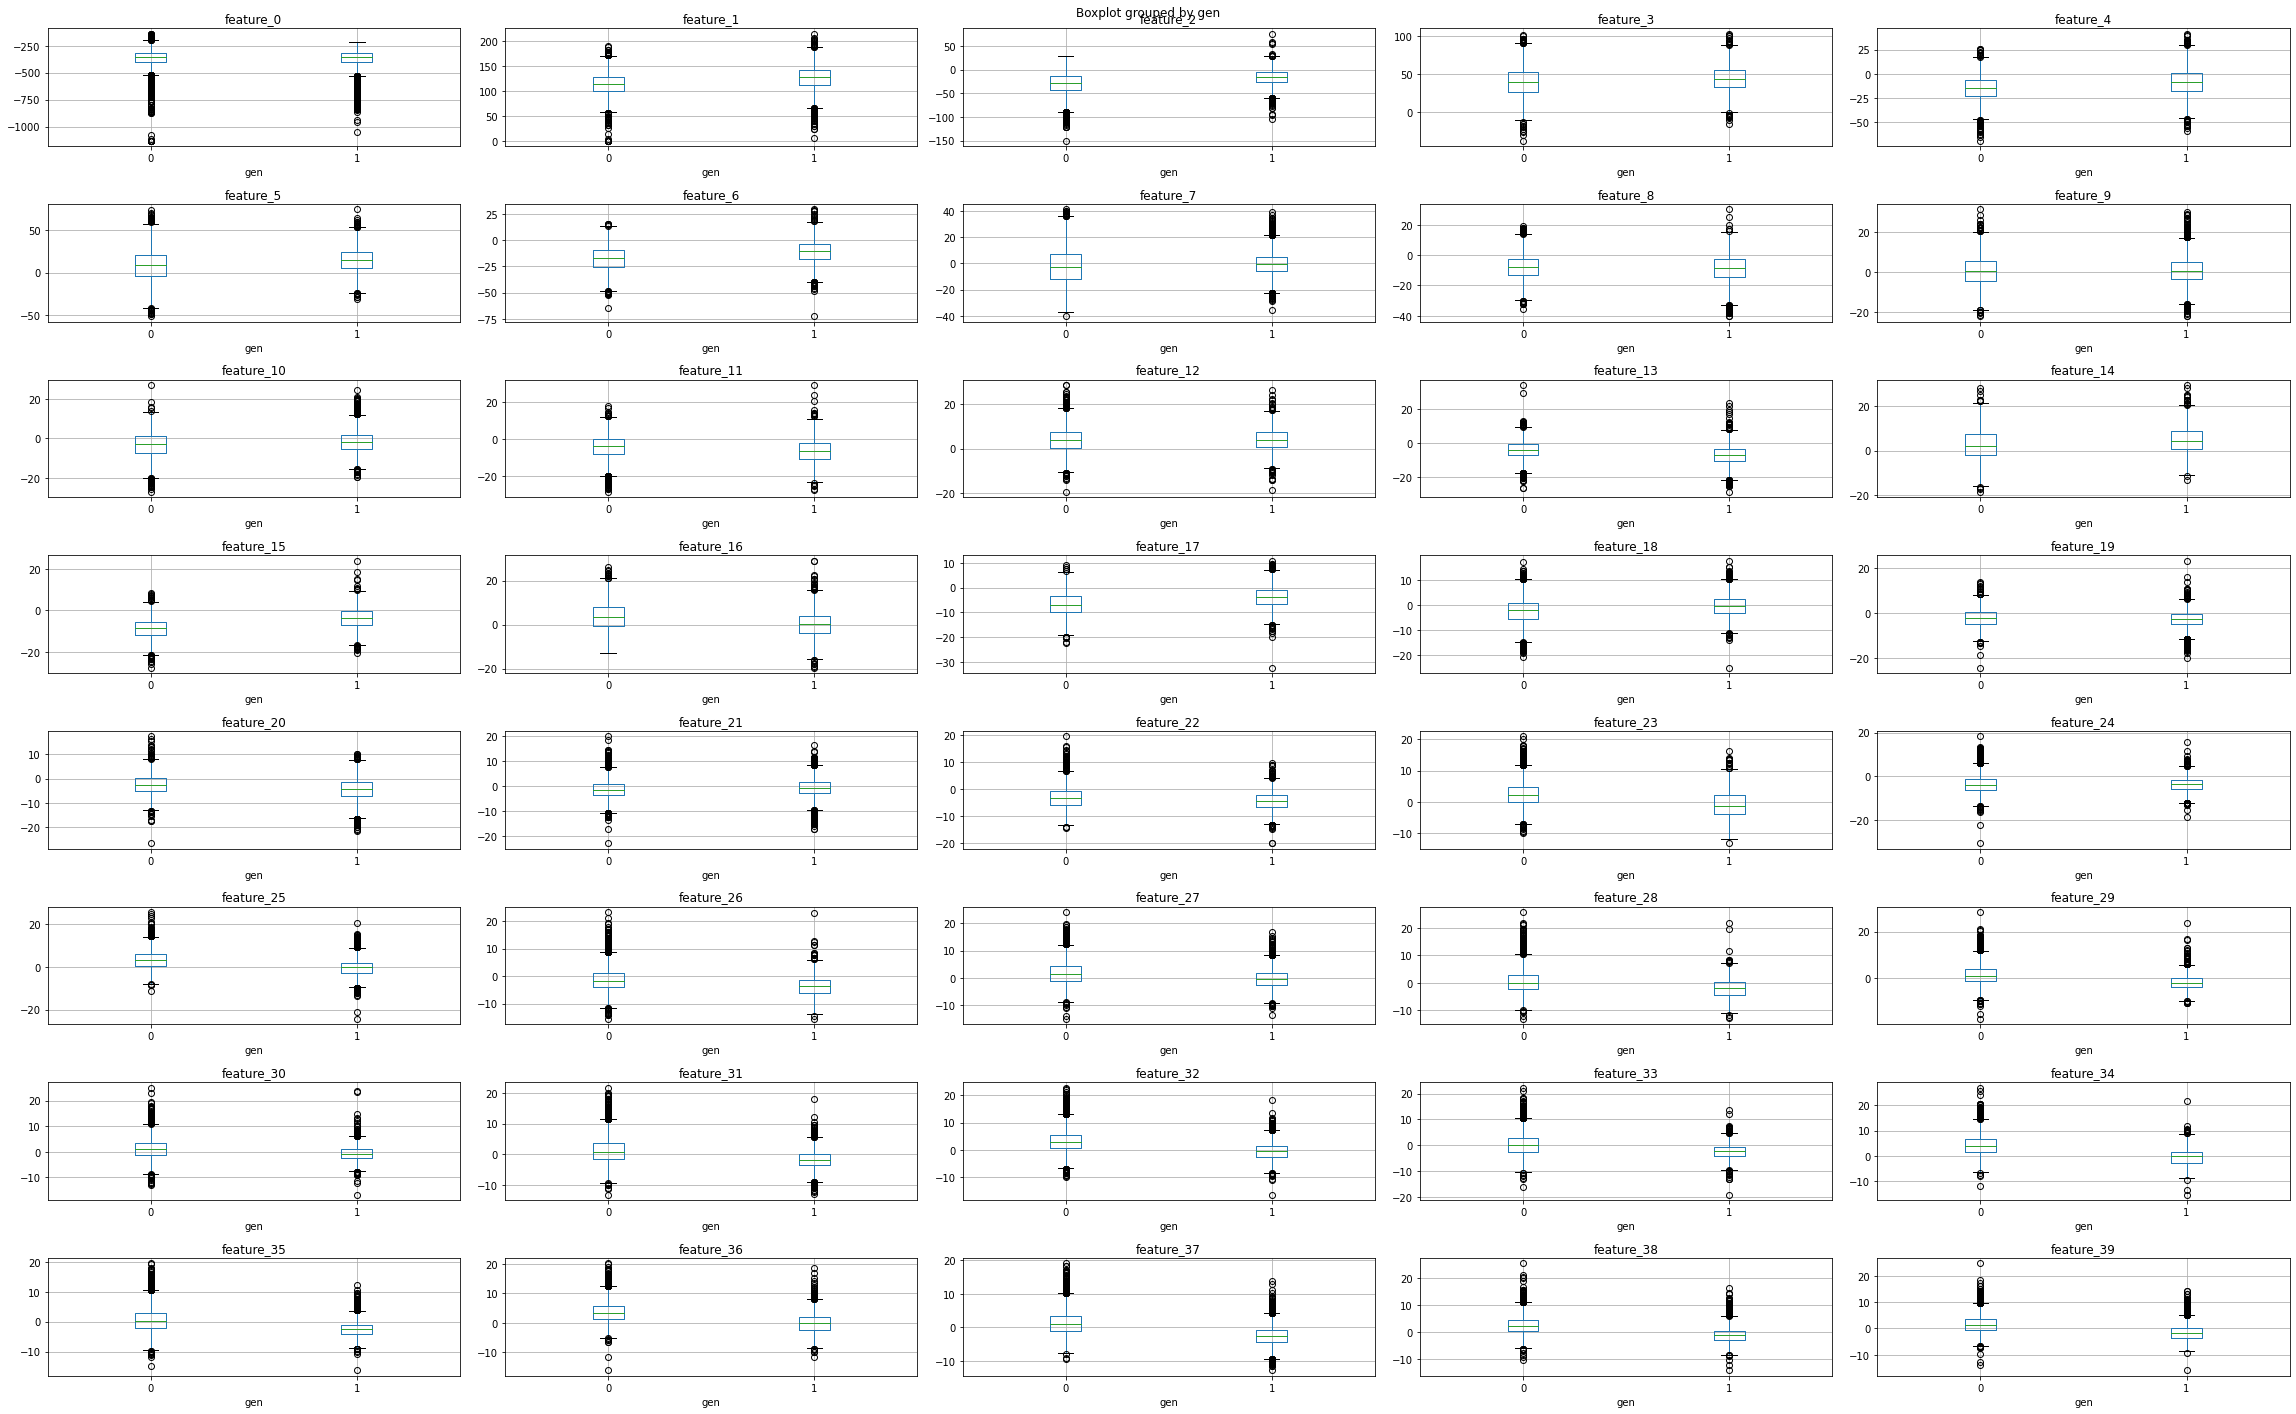

In [9]:
plt.rcParams["figure.figsize"] = (32,20)
fig, axes = plt.subplots(8,5)


for i,el in enumerate(filter_col):
    a = df.boxplot(el, by="gen", ax=axes.flatten()[i])


plt.tight_layout() 

plt.show()
                                 

Now we look at feature distributions, as we can see most of them can be considered normal, but a few like feature 0 are skewed.

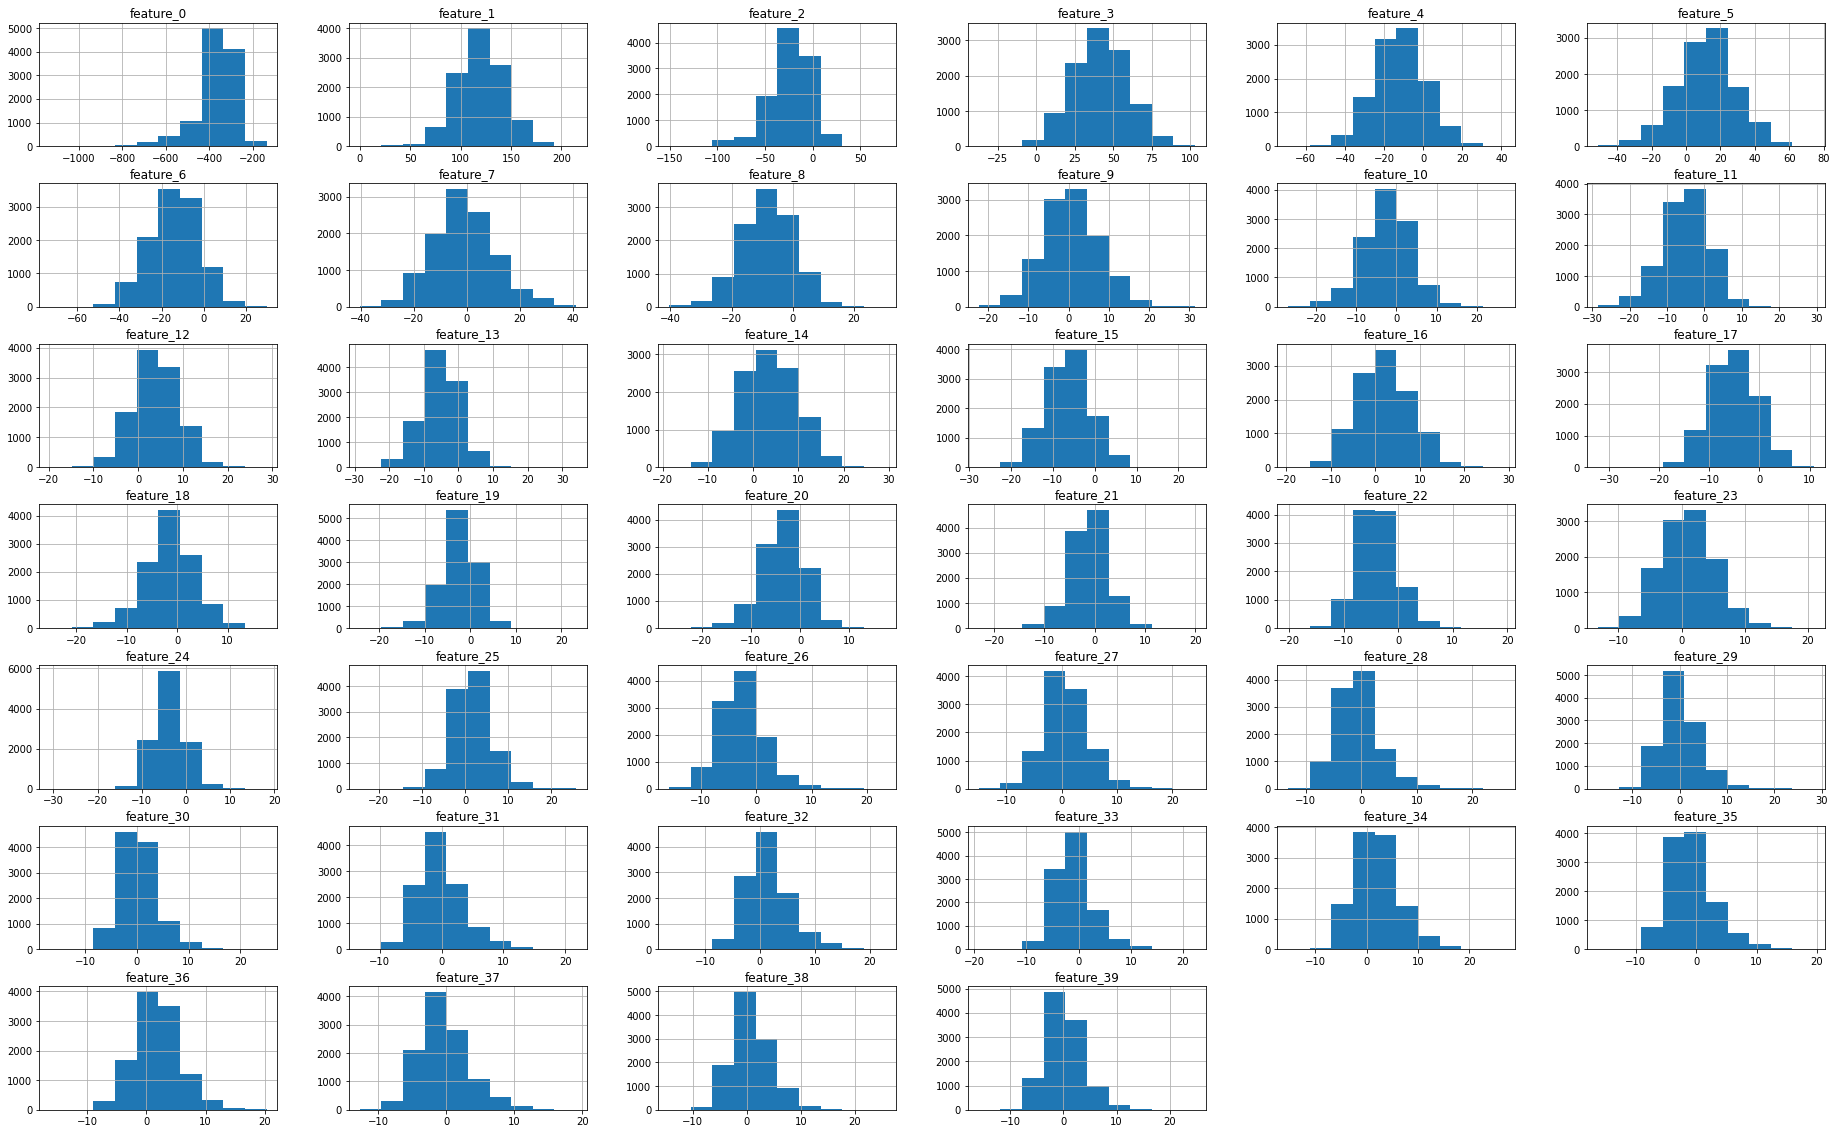

In [10]:
df[filter_col].hist();

In [11]:
df[filter_col].describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39
count,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,...,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000
mean,-370.844053,119.728215,-23.795025,41.575440,-11.966970,11.542157,-14.195862,-1.041392,-8.345472,0.643236,...,0.353782,-0.167688,1.460941,-0.916434,2.123001,-0.836542,1.840156,-0.421677,0.807749,0.147673
std,93.737696,23.491826,22.115180,17.782680,13.184018,17.191921,11.555352,11.848670,8.442314,6.935556,...,3.659788,3.820251,4.108391,3.764614,4.326424,3.704912,3.880942,3.704803,3.659551,3.444152
min,-1131.370972,0.000000,-150.452805,-37.353859,-69.058327,-51.355530,-72.738953,-40.402901,-40.437134,-22.313248,...,-16.825161,-13.272488,-16.502615,-19.156487,-15.237686,-16.298374,-16.216492,-12.757937,-14.365801,-15.963499
25%,-399.340393,104.168884,-35.851578,29.411257,-20.921677,0.456918,-21.999752,-9.012949,-13.915918,-3.897743,...,-2.010891,-2.747908,-1.352911,-3.418916,-0.748029,-3.357694,-0.688429,-2.912157,-1.587476,-2.221764
50%,-351.650909,119.673027,-21.749828,41.568172,-12.122043,12.079138,-13.646107,-1.462251,-8.248024,0.342405,...,0.007239,-0.630352,1.063356,-1.277053,1.739920,-1.356911,1.723838,-0.820295,0.518314,-0.140621
75%,-315.282654,134.848862,-8.523540,53.948277,-3.164124,22.523071,-6.248885,6.208583,-2.422522,5.072238,...,2.266276,1.784425,3.649436,0.976618,4.509115,1.115358,4.101736,1.614896,2.955017,2.169372
max,-137.025970,214.555878,76.443115,103.185959,41.646996,74.444794,29.740822,41.161198,30.334230,31.389622,...,25.104574,21.781826,22.844183,22.341635,26.852781,19.532040,20.275862,19.075527,25.671942,24.784950


Since we had considerable number of outliers (and not all of the features have normal distribution), we decided to use robust scaler for normalization. In this normalization instead of mean and variance, we consider percentiles which are less affected by the outliers (50 percentile will become zero). Feature distributions will remain the same.

In [12]:
# normalize
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler(unit_variance=True).fit(df[filter_col])
y=transformer.transform(df[filter_col])

In [13]:
df[filter_col]=pd.DataFrame(y)

In [14]:
df[filter_col].describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39
count,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,...,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000,11085.000000
mean,-0.308016,0.002427,-0.100956,0.000400,0.011780,-0.032827,-0.047084,0.037298,-0.011437,0.045241,...,0.109296,0.137705,0.107216,0.110673,0.098299,0.156932,0.032757,0.118781,0.085953,0.088565
std,1.504326,1.032921,1.091660,0.977644,1.001544,1.051001,0.989656,1.050066,0.990874,1.043026,...,1.154264,1.137039,1.107907,1.155352,1.110157,1.117324,1.092929,1.103964,1.086773,1.058061
min,-12.513141,-5.261948,-6.353097,-4.338922,-4.325251,-3.877978,-5.060994,-3.451041,-3.778035,-3.407143,...,-5.308786,-3.762738,-4.737004,-5.487159,-4.356441,-4.506034,-5.052256,-3.557200,-4.420120,-4.860869
25%,-0.765333,-0.681708,-0.696097,-0.668355,-0.668478,-0.710506,-0.715446,-0.669166,-0.665241,-0.637668,...,-0.636500,-0.630258,-0.651593,-0.657333,-0.638406,-0.603395,-0.679329,-0.623337,-0.625354,-0.639338
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.583647,0.667272,0.652882,0.680625,0.680502,0.638473,0.633533,0.679813,0.683739,0.711311,...,0.712480,0.718721,0.697386,0.691646,0.710574,0.745585,0.669650,0.725643,0.723625,0.709642
max,3.444354,4.171940,4.847046,3.387581,4.084647,3.812626,3.715864,3.777422,4.528398,4.669136,...,7.915471,6.670642,5.873621,7.248523,6.443942,6.299673,5.224518,5.928594,7.469846,7.657263


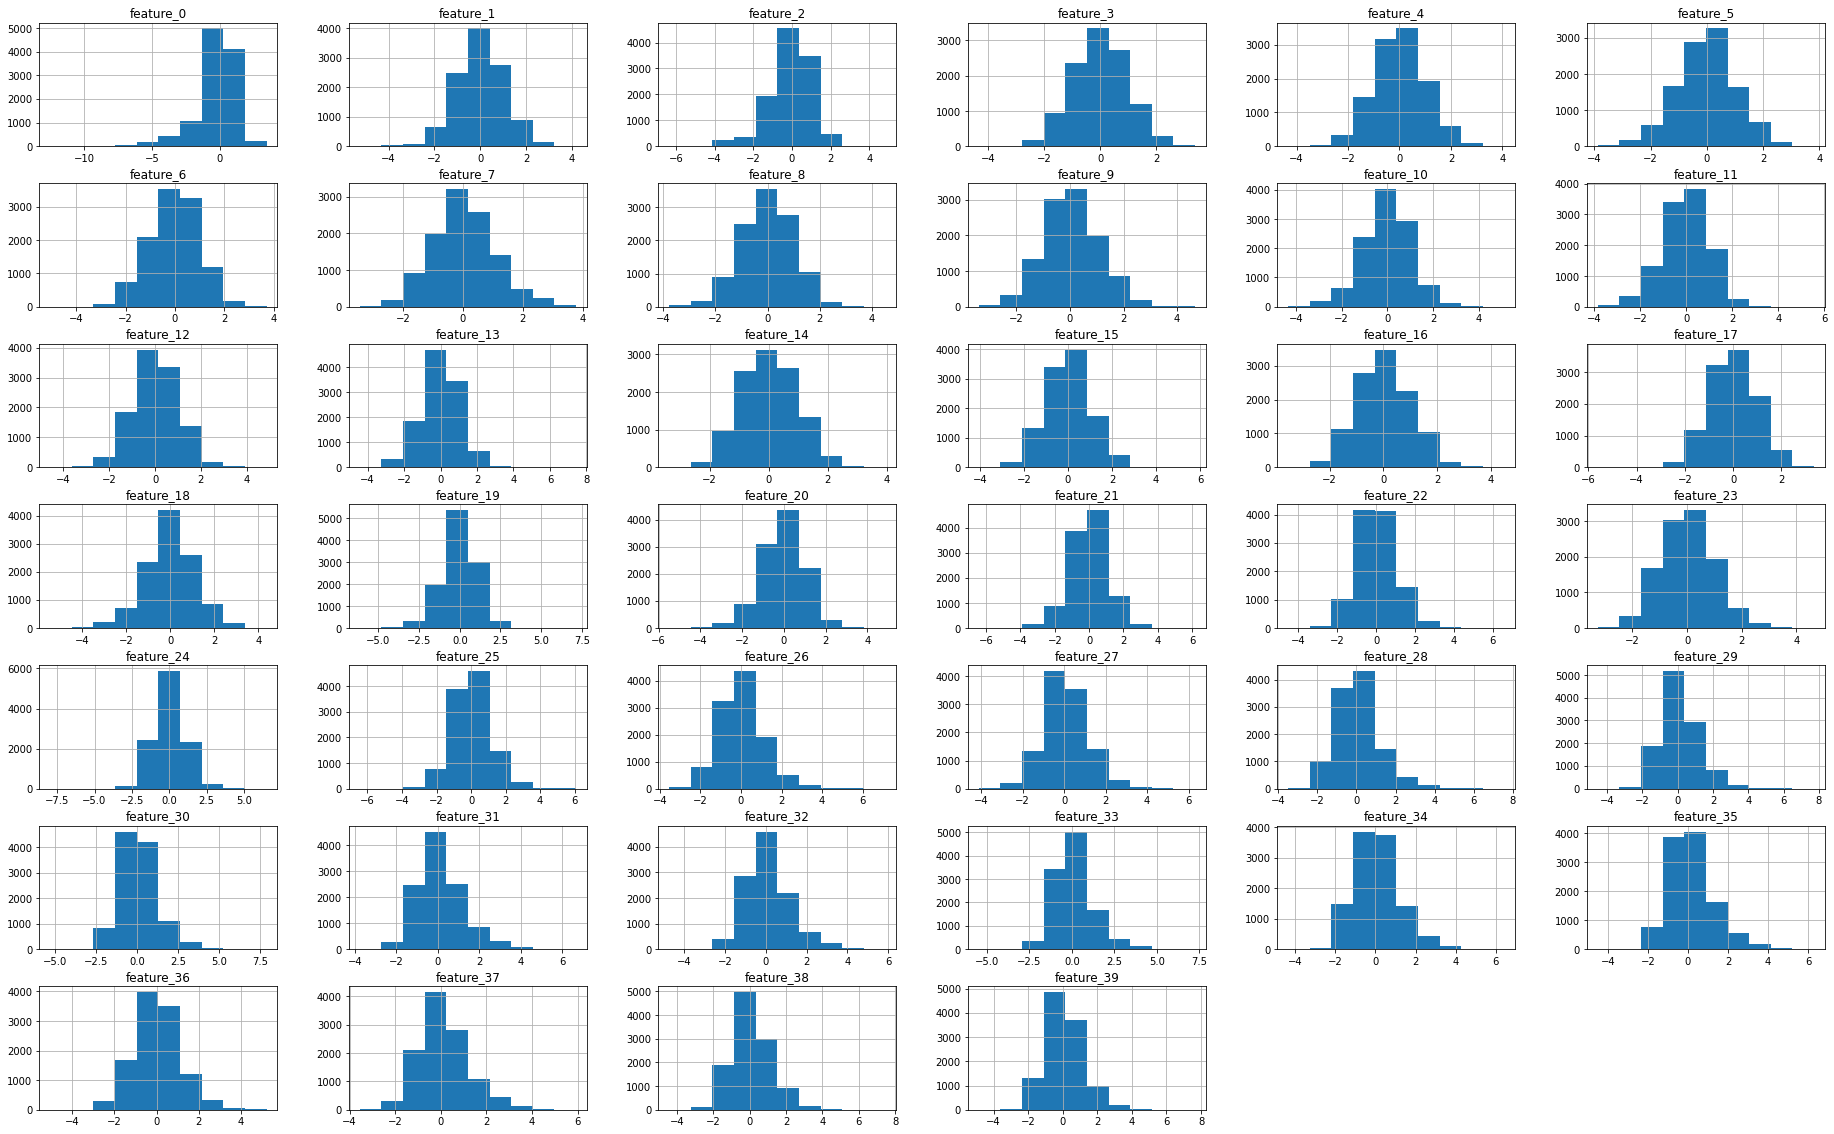

In [15]:
df[filter_col].hist();

For splitting the dataet to train and test, we want to have almost equal number of audio for females and males in both train and test. We also want to keep 80 percent for training and 20% for test. Since audios are equal for male and female, and number of male and female are the same, the number of audio per person should be almost the same, so we can have 80% of females in training set and 20% in test, we add all audios for that person to the related set, because we dont want to train and test on the same person. We do the same for males.

In [16]:
# 0.8 male and female in train, 0.2 in test
group=df.groupby(['speaker_id','S'])
speakers=group.groups.keys()
males=[]
females=[]
for speaker in speakers:
    if speaker[1]=='F':
        females.append(speaker[0])
    else:
        males.append(speaker[0])
males_in_train=males[:int(len(males)*0.8)]
males_in_train.remove(2078)
males_in_test=males[int(len(males)*0.8) :]
females_in_train=females[:int(len(females)*0.8)]
females_in_test=females[int(len(females)*0.8) :]

In [17]:
print(males_in_train)

[174, 251, 422, 652, 777, 1272, 2086, 2428, 2803, 2902, 3000, 3170, 3752, 5536]


In [18]:
males_train_data=df[df.speaker_id.isin(males_in_train)]
males_test_data=df[df.speaker_id.isin(males_in_test)]
females_train_data=df[df.speaker_id.isin(females_in_train)]
females_test_data=df[df.speaker_id.isin(females_in_test)]

We can see the train and test sets are almost balanced.

In [19]:
print('# of males in test:',len(males_test_data),'\n# of males in train:',len(males_train_data),'\n# of females in test:',len(females_test_data),'\n# of females in train:',len(females_train_data))

# of males in test: 1125 
# of males in train: 3859 
# of females in test: 1393 
# of females in train: 4439


In [20]:
train_data=males_train_data.append(females_train_data)

In [21]:
test_data=males_test_data.append(females_test_data)

In classification it is smetimes necessary to shuffle the training set, specially in cases when the traing is done stepwise like perceptron. So here we shuffle the training set.

In [22]:
shuffled_train=train_data.sample(frac=1)

Now we try to develop different classification algorithmes on our data.

In [23]:
def acc():
    accuracy = sklearn.metrics.accuracy_score(test_data['gen'].values, test_data['pred_gen'].values)
    print("\nAccuracy: ", accuracy)
    precision = sklearn.metrics.precision_score(test_data['gen'].values, test_data['pred_gen'].values)
    print("\nPrecision: ", precision)
    recall=sklearn.metrics.recall_score(test_data['gen'].values, test_data['pred_gen'].values)
    print("\nRecall: ", recall)

### Naive Bayes

This model assumes that features are not correlated, which is not true.

In [24]:
nb=GaussianNB()
nb.fit(shuffled_train[filter_col].values,shuffled_train['gen'].values)

GaussianNB()

In [25]:
test_data['pred_gen']=nb.predict(test_data[filter_col].values)

In [26]:
acc()


Accuracy:  0.8633836378077839

Precision:  0.8267782426778243

Recall:  0.8782222222222222


In the following models sometimes we need to train more than one model and choose the best one, so we split our training data to train_train and train_validation parts.

In [28]:
t_validation=shuffled_train[int(len(shuffled_train)*0.8):]
t_train=shuffled_train[:int(len(shuffled_train)*0.8)]
print(len(t_validation[t_validation.S=='F']),len(t_validation[t_validation.S=='M']))
print(len(t_train[t_train.S=='F']),len(t_train[t_train.S=='M']))

899 761
3540 3098


### Support vector machines

We did this part with two kinds of kernels:

1. with gaussian kernel: 

In [29]:
svc = svm.SVC()
svc.fit(shuffled_train[filter_col].values,shuffled_train['gen'].values)

SVC()

In [30]:
test_data['pred_gen'] = svc.predict(test_data[filter_col].values)

In [31]:
acc()


Accuracy:  0.9038919777601271

Precision:  0.8694560669456067

Recall:  0.9235555555555556


2. with polynomial kernel, using validation set to choose the polynomial degree:

In [32]:
b_acc=0
b_deg=0
for degree in range(2,15):
    svc = svm.SVC(degree=degree,kernel='poly')
    svc.fit(t_train[filter_col],t_train['gen'])
    accuracy =svc.score(t_validation[filter_col],t_validation['gen'])
    if accuracy > b_acc:
        b_acc = accuracy
        b_deg = degree
        print("degree : ", degree, ", accuracy on train: ", accuracy)

degree :  2 , accuracy on train:  0.9746987951807229
degree :  3 , accuracy on train:  0.9819277108433735


In [33]:
svc = svm.SVC(degree=b_deg,kernel='poly')
svc.fit(shuffled_train[filter_col].values,shuffled_train['gen'].values)
test_data['pred_gen'] = svc.predict(test_data[filter_col].values)

In [34]:
acc()


Accuracy:  0.8947577442414615

Precision:  0.8380503144654088

Recall:  0.9475555555555556


### Neural Network/ Multi-layer Perceptron (MLP)

We did this part with different number of hidden layers:

1. one hidden layer with 100 neurons:

In [35]:
mlp = MLPClassifier( random_state=1, max_iter=500)
mlp.fit(shuffled_train[filter_col].values,shuffled_train['gen'].values)
test_data['pred_gen'] = mlp.predict(test_data[filter_col].values)

In [36]:
acc()


Accuracy:  0.8959491660047657

Precision:  0.8635214827295703

Recall:  0.9111111111111111


2. Two hidden layers and using validation set for choosing number of neurons in hidden layers.

In [37]:
b_acc=0
b_deg=0
acc_list=[]
for degree in range(2,20):
    mlp = MLPClassifier(  hidden_layer_sizes=(degree, degree),random_state=1, max_iter=500)
    mlp.fit(t_train[filter_col].values,t_train['gen'].values)
    accuracy =mlp.score(t_validation[filter_col],t_validation['gen'])
    acc_list.append(accuracy)
    if accuracy > b_acc:
        b_acc = accuracy
        b_deg = degree
        print("degree : ", degree, ", accuracy on train: ", accuracy)

degree :  2 , accuracy on train:  0.946987951807229
degree :  3 , accuracy on train:  0.9632530120481928
degree :  4 , accuracy on train:  0.9692771084337349
degree :  5 , accuracy on train:  0.9698795180722891
degree :  6 , accuracy on train:  0.9795180722891567
degree :  15 , accuracy on train:  0.9801204819277108
degree :  16 , accuracy on train:  0.986144578313253


choose 15 neurons for each hidden layer and train on whole traing set and test on test set:

In [38]:
mlp = MLPClassifier(hidden_layer_sizes=(15, 15),random_state=1, max_iter=500)
mlp.fit(shuffled_train[filter_col].values,shuffled_train['gen'].values)
test_data['pred_gen'] = mlp.predict(test_data[filter_col].values)

In [39]:
acc()


Accuracy:  0.8899920571882446

Precision:  0.8557046979865772

Recall:  0.9066666666666666


### Deep learning/ CNN

For this part we use the main mfccs extracted from librosa, i.e. 3d array. We should consider that the length of each mfcc array is not equal for all audios, since we chunked audios to 2second, their length is usually 87, but for some (last chunk of the audio with length less than 2) we need to add padding to make all arrays have similar shapes.

In [133]:
x=t_train.mfccs.apply(lambda k: np.pad(k, pad_width=((0,0), (0, 87-k.shape[1])), mode='constant'))
x_v=t_validation.mfccs.apply(lambda k: np.pad(k, pad_width=((0,0), (0, 87-k.shape[1])), mode='constant'))

In [149]:
cnn_train = np.reshape(np.array(x.tolist()), [len(x), 40, 87, 1])
cnn_valid = np.reshape(np.array(x_v.tolist()), [len(x_v), 40, 87, 1])
cnn_train.shape

(6638, 40, 87, 1)

In [174]:
y_train=np.array(t_train.gen.tolist())
y_valid=np.array(t_validation.gen.tolist())

y_valid

array([0, 0, 1, ..., 1, 1, 0])

We make a three layed model with a layer of fully connected binary classifier.

In [191]:
cnn_model = tf.keras.Sequential([
#     first layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=2,input_shape=(40, 87, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
#     second layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
#     third layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
#     fully connected classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1028, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])


In [192]:
cnn_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [194]:
cnn_model.fit(cnn_train, y_train, batch_size=8, epochs=40, validation_data=(cnn_valid, y_valid))

Epoch 1/40
830/830 [==============================] - 63s 76ms/step - loss: 0.1125 - accuracy: 0.9497 - val_loss: 0.0885 - val_accuracy: 0.9578
Epoch 2/40
830/830 [==============================] - 64s 77ms/step - loss: 0.0886 - accuracy: 0.9610 - val_loss: 0.0836 - val_accuracy: 0.9596
Epoch 3/40
830/830 [==============================] - 65s 79ms/step - loss: 0.0794 - accuracy: 0.9684 - val_loss: 0.0932 - val_accuracy: 0.9554
Epoch 4/40
830/830 [==============================] - 67s 81ms/step - loss: 0.0747 - accuracy: 0.9696 - val_loss: 0.1341 - val_accuracy: 0.9554
Epoch 5/40
830/830 [==============================] - 65s 78ms/step - loss: 0.0577 - accuracy: 0.9754 - val_loss: 0.0839 - val_accuracy: 0.9572
Epoch 6/40
830/830 [==============================] - 65s 79ms/step - loss: 0.0569 - accuracy: 0.9754 - val_loss: 0.0920 - val_accuracy: 0.9620
Epoch 7/40
830/830 [==============================] - 65s 79ms/step - loss: 0.0441 - accuracy: 0.9845 - val_loss: 0.1065 - val_accuracy:

In [196]:
x_t=test_data.mfccs.apply(lambda k: np.pad(k, pad_width=((0,0), (0, 87-k.shape[1])), mode='constant'))
cnn_test = np.reshape(np.array(x_t.tolist()), [len(x_t), 40, 87, 1])
cnn_test.shape

(2518, 40, 87, 1)

In [198]:
y_test=np.array(test_data.gen.tolist())
y_test.shape

(2518,)

In [202]:
score = cnn_model.evaluate(cnn_test, y_test)
score

79/79 [==============================] - 3s 42ms/step - loss: 1.0632 - accuracy: 0.9301


[1.0631972551345825, 0.9301032423973083]

As we can see from the results, the worst model was naive bayes, with acc=0.863, since it was more simple and it considered features are independent. 

SVM and MLP were almost the same, with accuracy equal to 0.903 and 0.895 respectively. They both could capture non linearity for class boundries.

The best model is CNN with accuracy equal to 0.93 . 

# 2. Speaker Classification

We load audio in 2 second chunks, and compute features using wav2vec model. The same as previous task we use the mean of the extracted list of features, which will result in 512 feature per sample.

In [ ]:
import torch
import fairseq

chunk_length_ms = 2000 

cp_path = './wav2vec_small.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model.eval()

path='./LibriSpeech/dev-clean/'
i=0
li=[]

for adr, dirs, files in os.walk(path):
    for name in files:
        if name.endswith(".flac"):
            
            myaudio = AudioSegment.from_file(os.path.join(adr, name) , "flac") 
            print(name)
            chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

            #Export all of the individual chunks as wav files
            for i, chunk in enumerate(chunks):
                chunk_name = "chunk{0}.wav".format(i)
                print("exporting", chunk_name)
                chunk.export(chunk_name, format="wav")
                sound, sample_rate = librosa.load(chunk_name)
                sound=sound.reshape((1,len(sound)))
                try:
                    z = model.feature_extractor(torch.from_numpy(sound))
                    li.append([int(name.split('-')[0]),torch.mean(z[0],1).tolist()])
                except:
                    print('----------------------------exception')
                    print(sound.shape)

#             print('end of user'+name.split('-')[0])

df2=pd.DataFrame(li,columns=['speaker_id','features'])
df2


make one column for each feature

In [4]:
for i in range(len(df2.features[0])):
    df2['feature_'+str(i)]=df2.features.apply(lambda x: x[i])
df2.head()

,speaker_id,features,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,1272,"[-0.004977358505129814, -0.0030276060570031404...",-0.004977,-0.003028,-0.008067,0.005188,0.005569,-0.007410,0.002980,0.006657,...,0.001767,-0.017067,-0.003015,-0.003318,0.001751,0.000336,-0.003563,-0.004612,-0.000909,0.001506
1,1272,"[-0.009119979105889797, -0.00869397260248661, ...",-0.009120,-0.008694,-0.008278,0.004854,0.003298,-0.008968,0.001187,0.008315,...,-0.001772,-0.019255,-0.007898,-0.003913,-0.005172,-0.000508,-0.007777,0.000688,0.001575,0.001621
2,1272,"[-0.00635141134262085, -0.007803602144122124, ...",-0.006351,-0.007804,-0.006927,0.002479,-0.002537,-0.009432,0.000614,0.005405,...,-0.000754,-0.008989,-0.011971,-0.001196,-0.001278,-0.006437,-0.007369,0.004300,-0.000471,0.009150
3,1272,"[-0.007321867626160383, -0.003516725730150938,...",-0.007322,-0.003517,-0.005354,0.001921,0.004995,-0.007638,0.004863,0.003283,...,-0.001016,-0.011065,-0.011064,-0.004384,-0.001218,-0.000632,-0.004458,-0.001058,-0.004443,-0.001566
4,1272,"[-0.0056882742792367935, -0.008358800783753395...",-0.005688,-0.008359,-0.008488,0.002417,0.001204,-0.009641,0.003537,0.007008,...,0.001691,-0.020921,-0.006222,0.001287,-0.005066,0.000665,-0.004421,-0.000469,0.000726,0.004552


For making train and test sets, we use each speakers audios (without shuffling them snce we don't want to use 2s of an audio in train and another 2s of the same audio in test) and put 0.8 in train and 0.2 in test per person.

In [5]:
test_df=pd.DataFrame(columns=['speaker_id','features'])
train_df=pd.DataFrame(columns=['speaker_id','features'])

for sid in df2.speaker_id.unique():
    df_temp=df2[df2['speaker_id']==sid]
    train=df_temp[:int(len(df_temp)*0.8)]
    train_df=pd.concat([train_df, train], axis=0)
    test=df_temp[int(len(df_temp)*0.8):]
    test_df=pd.concat([test_df, test], axis=0)

# print(len(df_temp), len(test), len(train))

2021-12-09 20:17:35 | INFO | numexpr.utils | NumExpr defaulting to 8 threads.


In [7]:
test_df

,speaker_id,features,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
220,1272,"[-0.0038690909277647734, -0.005991621874272823...",-0.003869,-0.005992,-0.011442,0.005187,0.000368,-0.011767,-0.001573,0.003278,...,0.003495,-0.008382,-0.011111,-0.006941,0.002205,-0.002646,-0.004431,0.002947,-0.006770,0.000045
221,1272,"[-0.004928166046738625, -0.005040026735514402,...",-0.004928,-0.005040,-0.010053,0.008433,0.000845,-0.006698,0.000496,0.008476,...,0.001721,-0.017897,-0.001599,-0.003960,0.003044,-0.006293,0.000368,-0.004321,0.000924,0.011322
222,1272,"[-0.003301231423392892, -0.004470164887607098,...",-0.003301,-0.004470,-0.006441,0.003467,0.001323,-0.007652,0.000791,0.005704,...,0.003427,-0.011623,-0.008170,-0.002344,0.005221,-0.002485,0.000828,-0.001921,-0.003003,0.005253
223,1272,"[-0.004678554367274046, -0.0062006497755646706...",-0.004679,-0.006201,-0.006227,0.007218,0.003820,-0.010437,0.004696,0.005497,...,0.002145,-0.020697,0.001770,-0.002646,0.000881,0.001636,-0.003639,-0.002753,-0.002179,-0.000899
224,1272,"[-0.005885777994990349, -0.006203622091561556,...",-0.005886,-0.006204,-0.004570,0.003170,0.001321,-0.010165,0.006255,0.005252,...,0.001559,-0.013855,-0.006070,-0.002613,0.006581,-0.001625,-0.001591,-0.001628,-0.002634,0.007181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,8842,"[-0.005255378782749176, -0.001120073487982154,...",-0.005255,-0.001120,-0.004625,0.002731,-0.000201,-0.000948,0.004284,0.006196,...,-0.002362,-0.010385,-0.012702,-0.003024,0.002233,0.000152,0.003730,-0.006507,0.001591,-0.014356
11060,8842,"[-0.004699772223830223, -0.002336304634809494,...",-0.004700,-0.002336,-0.004835,0.003294,0.000898,-0.002882,0.002472,0.003218,...,-0.004124,-0.014991,-0.013790,-0.004986,0.003462,0.000558,0.000871,-0.007150,0.002021,-0.008303
11061,8842,"[-0.0028823395259678364, -0.003440388012677431...",-0.002882,-0.003440,-0.001627,0.002260,-0.000758,-0.004068,0.002681,0.000285,...,-0.000684,-0.009245,-0.022899,-0.004480,0.002887,0.004024,0.001248,-0.004722,-0.001749,-0.011108
11062,8842,"[-0.007302934303879738, 0.00040870855445973575...",-0.007303,0.000409,-0.008486,0.002573,0.003122,-0.001493,0.006198,0.007886,...,0.000947,-0.006610,-0.014060,-0.006802,0.005989,-0.003527,-0.000874,-0.005385,-0.000536,-0.020519


We shuffle the training set.

In [8]:
train_shuffled=train_df.sample(frac=1)
train_shuffled

,speaker_id,features,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
7008,5536,"[-0.008000265806913376, -0.010232795961201191,...",-0.008000,-0.010233,-0.010107,-0.001825,-0.002705,-0.005991,0.006318,0.010508,...,-0.002069,-0.020586,-0.030240,-0.002536,-0.005594,0.000392,-0.017648,0.001894,0.009399,0.001606
972,174,"[-0.0052160536870360374, -0.003566384082660079...",-0.005216,-0.003566,-0.004306,0.010045,0.002603,-0.001988,0.005877,0.000821,...,-0.000112,-0.004384,-0.025911,-0.003255,-0.001463,-0.001619,-0.004424,-0.000709,-0.000571,0.001540
10157,7976,"[-0.001620223862119019, -0.002392703900113702,...",-0.001620,-0.002393,0.000026,0.001931,0.003702,-0.004342,0.007593,-0.002441,...,-0.000024,-0.011438,-0.013520,-0.001698,0.004972,0.002838,-0.002692,-0.002874,-0.000158,-0.004223
444,1462,"[-0.003987699747085571, -0.0015151036204770207...",-0.003988,-0.001515,-0.000978,0.005577,0.000551,-0.000695,0.003343,0.000117,...,-0.004121,-0.004288,-0.020148,0.000618,-0.000696,0.000391,0.002945,-0.005628,0.002458,-0.006005
8893,6345,"[-0.004845216404646635, 0.0012168994871899486,...",-0.004845,0.001217,-0.002690,0.000875,-0.001258,-0.004549,0.000056,0.003170,...,-0.001330,-0.010851,-0.016244,-0.003531,0.002463,-0.002358,-0.002880,-0.000567,0.001602,-0.015402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,3170,"[-0.0020980006083846092, -0.001371432561427354...",-0.002098,-0.001371,-0.004026,-0.000044,0.001294,-0.006048,0.009899,0.005173,...,0.001682,-0.006887,-0.020688,-0.006627,0.005720,0.003429,-0.001805,-0.009069,-0.003248,0.008925
3090,2412,"[-0.005064832977950573, 0.0009546906221657991,...",-0.005065,0.000955,-0.003135,0.001355,0.003328,-0.003465,-0.002185,0.000876,...,-0.003001,-0.009746,-0.019556,-0.002249,0.002623,0.002494,0.002459,-0.009205,-0.001177,0.003583
322,1462,"[-0.0029097762890160084, -2.002021392399911e-0...",-0.002910,-0.000020,-0.001817,0.003715,0.000882,-0.002823,-0.000702,0.003657,...,0.000825,-0.004960,-0.020816,-0.001529,0.005295,-0.000845,0.000225,0.000084,0.000162,-0.010310
3313,2428,"[-0.015499936416745186, -0.004104936961084604,...",-0.015500,-0.004105,-0.007899,0.001172,0.004454,-0.003551,0.008935,0.005749,...,-0.001767,-0.007579,-0.005152,-0.003090,-0.008802,-0.004177,-0.010123,-0.001716,0.004342,-0.005181


Make speaker ids number:

In [9]:
train_shuffled['speaker_id']=pd.to_numeric(train_shuffled['speaker_id'])
test_df['speaker_id']=pd.to_numeric(test_df['speaker_id'])

Train MLP model for speaker classification:

In [10]:
filter_col = [col for col in test_df if col.startswith('feature_')]

mlp = MLPClassifier(random_state=1, max_iter=500)
mlp.fit(train_shuffled[filter_col].values , train_shuffled['speaker_id'].values)
test_df['pred_id'] = mlp.predict(test_df[filter_col].values)

In [11]:
accuracy = sklearn.metrics.accuracy_score(test_df.speaker_id, test_df['pred_id'])
print("\nAccuracy: ", accuracy)
precision = sklearn.metrics.precision_score(test_df.speaker_id, test_df['pred_id'], average='macro')
print("\nPrecision: ", precision)
recall=sklearn.metrics.recall_score(test_df.speaker_id, test_df['pred_id'], average='macro')
print("\nRecall: ", recall)


Accuracy:  0.9546678635547576

Precision:  0.956260662680932

Recall:  0.9545855683763605


Now we perform dimentionality reduction and visualization using two algorithms:

### PCA

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(df2[filter_col].values)

pca = PCA(n_components=3)
new_data = pca.fit_transform(x)
pca_df = pd.DataFrame(data = new_data, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

pca_df['speaker_id']=df2['speaker_id']
pca_df

,principal component 1,principal component 2,principal component 3,speaker_id
0,-3.312734,3.065400,-1.455524,1272
1,-7.698118,9.887351,2.693841,1272
2,1.970107,2.730535,-3.598171,1272
3,-4.702788,4.732455,1.213964,1272
4,-9.364262,8.196379,-0.140783,1272
...,...,...,...,...
11059,-0.730425,-4.733923,-0.972956,8842
11060,-2.533935,-5.196839,1.751384,8842
11061,-7.059098,-6.109956,0.616652,8842
11062,-1.577204,-4.819282,-2.238997,8842


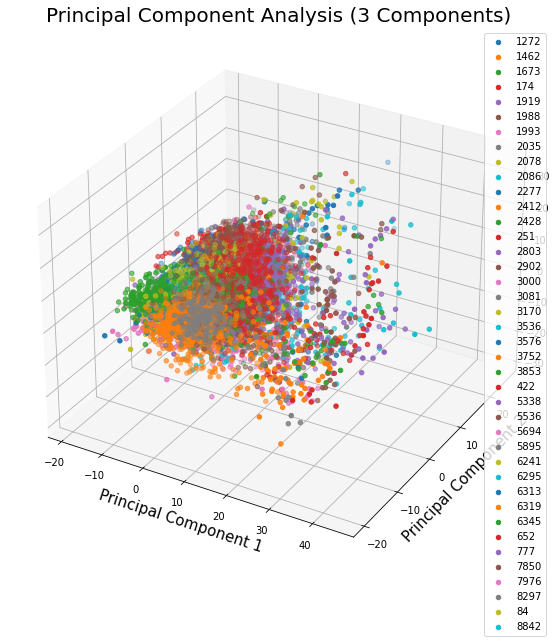

In [18]:
plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
# plt.zlabel('Principal Component 3', fontsize = 15)

plt.title('Principal Component Analysis (3 Components)', fontsize = 20)
targets = df2.speaker_id.unique()
colors = range(40)
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['speaker_id'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'],
                pca_df.loc[indicesToKeep, 'principal component 3'],
              zdir='Z')
ax.legend(targets)
# plt.axis([-3,3,-3,3])
plt.grid()

### t-SNE

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=1)
tsne_result = tsne.fit_transform(x)
tsne_df = pd.DataFrame({'x':tsne_result[:,0], 'y':tsne_result[:,1], 'z':tsne_result[:,2], 'speaker_id':df2['speaker_id']})
tsne_df

,x,y,z,speaker_id
0,-19.981058,4.769900,8.257921,1272
1,-24.118046,4.620122,7.056281,1272
2,-11.250597,7.229754,8.564878,1272
3,-18.953043,4.609463,7.368234,1272
4,-23.075890,3.822158,9.927564,1272
...,...,...,...,...
11059,-5.545209,-5.848015,-13.228069,8842
11060,-5.314301,-6.097433,-13.605494,8842
11061,-4.919667,-6.331619,-14.378999,8842
11062,3.163696,-11.799958,-21.408674,8842


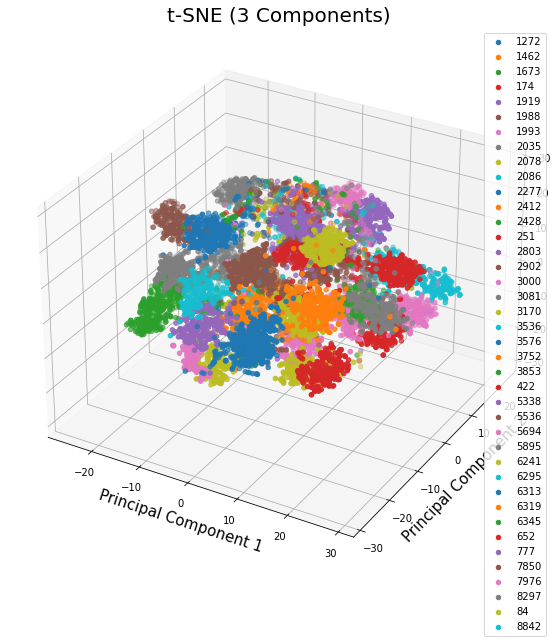

In [22]:
plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)

plt.title('t-SNE (3 Components)', fontsize = 20)
targets = df2.speaker_id.unique()
colors = range(40)
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['speaker_id'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 'x']
               , tsne_df.loc[indicesToKeep, 'y'],
                tsne_df.loc[indicesToKeep, 'z'],
              zdir='x')
ax.legend(targets)
# plt.axis([-3,3,-3,3])
plt.grid()

Here we have used repetative colors (red is assigned to for ids, so we see 4 red clusters). we can see that t-SNE, non-linear, represent better than PCA, linear, the clusters as it can better preserve the local similarities in the dataset (similar samples are represented close together in final visualization).